# LSTM Stock Price Prediction with Bias-Variance and Extreme-Error Analysis

In [5]:
from google.colab import files
uploaded = files.upload()

Saving SP500_2002_2022.csv to SP500_2002_2022.csv


In [12]:

# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


# Set random seed for reproducibility
np.random.seed(42)


In [13]:

# Preprocessing function
def preprocess_and_feature(data):
    df = data.copy()

    print("Handling missing values...")
    df = df.dropna()

    # Target is 'close', others are features
    features = [col for col in df.columns if col != 'date' and col != 'Year_Month' and col != 'close']

    scaler_features = StandardScaler()
    scaler_close = StandardScaler()

    data_scaled = pd.DataFrame(
        scaler_features.fit_transform(df[features]),
        columns=features
    )
    data_scaled['close'] = scaler_close.fit_transform(df[['close']])

    return data_scaled, features, scaler_close


In [8]:

# Sequence preparation for LSTM
def prepare_sequences_lstm(data_scaled, features, seq_length):
    X, y = [], []

    for i in range(len(data_scaled) - seq_length - 1):
        sequence = data_scaled[features].iloc[i:(i + seq_length)].values
        X.append(sequence)
        y.append(data_scaled['close'].iloc[i + seq_length + 1])

    X = np.array(X)
    y = np.array(y)

    print(f"X shape for LSTM: {X.shape}")  # (samples, timesteps, features)
    return X, y


In [9]:

# Load data
data = pd.read_csv("SP500_2002_2022.csv")
data_scaled, features, scaler_close = preprocess_and_feature(data)

# Prepare sequences
seq_length = 60
X, y = prepare_sequences_lstm(data_scaled, features, seq_length)


Handling missing values...
X shape for LSTM: (4974, 60, 14)


In [20]:
def train_lstm_model(X_train, y_train, X_val, y_val, config):
    """
    Train LSTM model with configurable hidden dimensions for multiple layers.
    """
    model = Sequential()

    # Regularization parameters
    l1_lambda = config.get('l1_lambda', 0)
    l2_lambda = config.get('l2_lambda', 0)

    # Add LSTM layers based on `hidden_dims`
    for i, units in enumerate(config['hidden_dims']):
        model.add(LSTM(
            units=units,
            return_sequences=i < len(config['hidden_dims']) - 1,  # Return sequences for all but the last layer
            input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None,  # Input shape for the first layer
            kernel_regularizer=regularizers.l1_l2(l1=l1_lambda, l2=l2_lambda)  # Add L1/L2 regularization
        ))
        model.add(Dropout(config['dropout_rate']))  # Add dropout after each LSTM layer

    # Add Dense output layer
    model.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=config['lr'])
    model.compile(optimizer=optimizer, loss='mse')

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        verbose=1
    )

    train_loss = history.history['loss']  # Training loss for all epochs
    val_loss = history.history['val_loss']  # Validation loss for all epochs

    return model, train_loss, val_loss






def bias_variance_analysis(data_scaled, features, scaler_close, base_config):
    """
    Perform Bias-Variance Analysis using Time Series Cross Validation.

    Args:
        data_scaled (pd.DataFrame): Scaled data including features and target.
        features (list): List of feature column names.
        scaler_close (StandardScaler): Scaler for the 'close' target.
        base_config (dict): Configuration for the LSTM model.

    Returns:
        bias (float): Calculated bias.
        variance (float): Calculated variance.
    """
    X, y = prepare_sequences_lstm(data_scaled, features, base_config['seq_length'])
    tscv = TimeSeriesSplit(n_splits=5)  # Time series cross-validation
    y_pre = []  # Store predictions for each fold
    y_true = []  # Store actual values for each fold

    print("Bias-Variance Analysis")
    for train_idx, val_idx in tscv.split(X):
        # Split data into train and validation sets
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train LSTM model with base configuration
        model, _, _ = train_lstm_model(
            X_train, y_train, X_val, y_val,
            config=base_config
        )

        # Predict on validation set
        val_pred = model.predict(X_val).squeeze()

        # Restore target values to original scale
        val_pred = scaler_close.inverse_transform(val_pred.reshape(-1, 1)).squeeze()
        y_val_true = scaler_close.inverse_transform(y_val.reshape(-1, 1)).squeeze()

        y_pre.append(val_pred)
        y_true.append(y_val_true)

    y_pre = np.array(y_pre)
    y_true = np.array(y_true)

    # Calculate bias and variance
    mean_pred = np.mean(y_pre, axis=0)
    mean_true = np.mean(y_true, axis=0)

    bias = np.mean((mean_pred - mean_true) ** 2)
    variance = np.var(y_pre, axis=0).mean()

    # Visualizations
    plt.figure(figsize=(15, 5))
    for i in range(len(y_pre)):
        plt.plot(y_pre[i][:100], alpha=0.3, label=f'Fold {i+1}')
    plt.title('Predictions Across Folds')
    plt.legend()
    plt.show()

    # Print Bias-Variance Analysis results
    print("\nBias-Variance Analysis Results:")
    print(f"Average Bias: {bias:.6f}")
    print(f"Average Variance: {variance:.6f}")
    print(f"Total Error（Bias + Variance）: {bias + variance:.6f}")

    if bias > variance:
        print("\nModel shows high bias (underfitting). Recommendations:")
        print("1. Increase model complexity")
        print("2. Reduce regularization")
        print("3. Add more features")
    elif variance > bias:
        print("\nModel shows high variance (overfitting). Recommendations:")
        print("1. Increase regularization")
        print("2. Reduce model complexity")
        print("3. Add more training data")
    else:
        print("\nModel shows good bias-variance trade-off")

    return bias, variance


def conduct_ablation_study(data_scaled, features, scaler_close, base_config):
    """
    Conduct ablation study to analyze the impact of various configurations on model performance.

    Args:
        data_scaled (pd.DataFrame): Scaled data including features and target.
        features (list): List of feature column names.
        scaler_close (StandardScaler): Scaler for the 'close' target.
        base_config (dict): Base configuration for the LSTM model.

    Returns:
        results (dict): Dictionary of results for each configuration tested.
    """
    # Define different configurations to test
    configurations = {
        'base_model': base_config,
        'short_sequence': {**base_config, 'seq_length': 4},
        'long_sequence': {**base_config, 'seq_length': 15},
        'high_dropout': {**base_config, 'dropout_rate': 0.5},
        'low_dropout': {**base_config, 'dropout_rate': 0.1},
        'high_lr': {**base_config, 'lr': 0.01},
        'low_lr': {**base_config, 'lr': 0.0001},
        'minimal_network': {**base_config, 'hidden_dims': [32]},
        'shallow_network': {**base_config, 'hidden_dims': [64, 32]},
        'deeper_network': {**base_config, 'hidden_dims': [128, 64, 32]}

    }

    results = {}
    tscv = TimeSeriesSplit(n_splits=5)  # 5-fold Time Series Cross Validation

    for name, config in configurations.items():
        print(f"\nTesting configuration: {name}")
        fold_scores = []
        fold_errors = []
        all_train_losses = []
        all_val_losses = []

        # Prepare sequences with the specific sequence length
        X, y = prepare_sequences_lstm(data_scaled, features, config['seq_length'])

        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            # Split data into train and validation sets
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Train the LSTM model with the current configuration
            model, train_loss, val_loss = train_lstm_model(
                X_train, y_train, X_val, y_val, config
            )

            # Validate the model and calculate R2 scores
            y_pred = model.predict(X_val).squeeze()
            y_pred = scaler_close.inverse_transform(y_pred.reshape(-1, 1)).squeeze()
            y_val_true = scaler_close.inverse_transform(y_val.reshape(-1, 1)).squeeze()

            fold_r2 = r2_score(y_val_true, y_pred)
            fold_scores.append(fold_r2)
            fold_errors.extend(np.abs(y_val_true - y_pred))
            all_train_losses.append(train_loss)
            all_val_losses.append(val_loss)

        # Store results for the current configuration
        results[name] = {
            'mean_r2': np.mean(fold_scores),
            'std_r2': np.std(fold_scores),
            'errors': fold_errors,
            'train_losses': np.mean(all_train_losses, axis=0),
            'val_losses': np.mean(all_val_losses, axis=0),
            'config': config
        }

        print(f"Configuration {name}: Mean R2 = {np.mean(fold_scores):.4f}, Std R2 = {np.std(fold_scores):.4f}")

    return results

def analyze_extreme_errors(predictions, actuals):
    errors = np.abs(predictions - actuals)
    extreme_errors_idx = errors > np.percentile(errors, 95)

    print("\nExtreme Error Analysis:")
    print(f"Number of extreme errors (95th percentile): {np.sum(extreme_errors_idx)}")
    print(f"Mean Error: {np.mean(errors):.6f}")
    print(f"Std Error: {np.std(errors):.6f}")
    print(f"95th Percentile Error: {np.percentile(errors, 95):.6f}")

    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    plt.hist(errors, bins=50, alpha=0.7)
    plt.title('Error Distribution')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')


    plt.subplot(1, 3, 2)
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.scatter(actuals[extreme_errors_idx], predictions[extreme_errors_idx],
                color='red', label='Extreme Errors')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--', label='Perfect Prediction')
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title('Actual vs Predicted')
    plt.legend()


    plt.subplot(1, 3, 3)
    plt.hist(errors[extreme_errors_idx], bins=20, color='orange', alpha=0.7)
    plt.title('Extreme Errors Distribution')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return extreme_errors_idx
def predict_returns(data, seq_length=5):
    """
    Preprocess data, train a single-layer LSTM model, and make predictions.
    """
    data_scaled, features, scaler_close = preprocess_and_feature(data)

    base_config = {
        'seq_length': seq_length,
        'hidden_dims': [64],  # Single-layer LSTM with 64 units
        'dropout_rate': 0.2,
        'lr': 0.001,
        'epochs': 50,
        'batch_size': 32,
        'l1_lambda': 0.0001,
        'l2_lambda': 0
    }

    print("\nStep 1: Performing Bias-Variance Analysis")
    bias, variance = bias_variance_analysis(data_scaled, features, scaler_close, base_config)
    print(f"Bias: {bias:.6f}, Variance: {variance:.6f}")

    print("\nStep 2: Conducting Ablation Study")
    ablation_results = conduct_ablation_study(data_scaled, features, scaler_close, base_config)

    best_config_name = max(ablation_results.keys(), key=lambda k: ablation_results[k]['mean_r2'])
    best_config = ablation_results[best_config_name]['config']
    print(f"\nBest Configuration: {best_config_name}")
    print(f"Details: {best_config}")

    print("\nStep 3: Training Final Model with Best Configuration")
    X, y = prepare_sequences_lstm(data_scaled, features, best_config['seq_length'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    model, train_losses, val_losses = train_lstm_model(
        X_train, y_train, X_test, y_test, best_config
    )

    print("\nStep 4: Making Predictions and Evaluating Final Model")
    predictions = model.predict(X_test)
    predictions = scaler_close.inverse_transform(predictions.reshape(-1, 1)).squeeze()
    actuals = scaler_close.inverse_transform(y_test.reshape(-1, 1)).squeeze()

    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print("\nFinal Model Metrics:")
    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R2 Score: {r2:.6f}")

    print("\nStep 5: Analyzing Extreme Errors")
    extreme_errors = analyze_extreme_errors(predictions, actuals)

    # Visualization
    print("\nStep 6: Visualizing Results")

    test_dates = data.iloc[-(len(predictions)):]['date'].values
    fig, ax = plt.subplots(figsize=(15, 7))

    ax.plot(test_dates, actual_values, label='Actual Returns', alpha=0.7)
    ax.plot(test_dates, predictions, label='Predicted Returns', alpha=0.7)

    n_ticks = 10
    step = len(test_dates) // n_ticks
    plt.xticks(test_dates[::step], test_dates[::step], rotation=45)

    plt.title('Return Predictions vs Actual Values')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return predictions, actuals, train_losses, val_losses



Handling missing values...

Step 1: Performing Bias-Variance Analysis
X shape for LSTM: (5029, 5, 14)
Bias-Variance Analysis
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4084 - val_loss: 0.1093
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0512 - val_loss: 0.1001
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0450 - val_loss: 0.0940
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0412 - val_loss: 0.0896
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0403 - val_loss: 0.0848
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0366 - val_loss: 0.0796
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0356 - val_loss: 0.0754
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0338 - val_loss: 0.0729
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0308 - val_loss: 0.0664
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0300 - val_loss: 0.0587
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0283 - val_loss: 0.0541
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0276 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3079 - val_loss: 0.0715
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0481 - val_loss: 0.0727
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0423 - val_loss: 0.0593
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0381 - val_loss: 0.0523
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0338 - val_loss: 0.0379
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0308 - val_loss: 0.0354
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295 - val_loss: 0.0298
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - val_loss: 0.0261
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0248 - val_loss: 0.0248
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0238 - val_loss: 0.0250
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 - val_loss: 0.0243
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209 - val_loss: 0.0241

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2118 - val_loss: 0.0375
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0419 - val_loss: 0.0304
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0364 - val_loss: 0.0274
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0312 - val_loss: 0.0253
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0283 - val_loss: 0.0228
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0248 - val_loss: 0.0211
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0225 - val_loss: 0.0197
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0205 - val_loss: 0.0176
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0190 - val_loss: 0.0154
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176 - val_loss: 0.0142
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0131
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - val_loss: 0.0117


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1376 - val_loss: 0.0406
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0355 - val_loss: 0.0256
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295 - val_loss: 0.0205
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0237 - val_loss: 0.0173
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199 - val_loss: 0.0149
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0129
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.0113
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 - val_loss: 0.0101
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0088
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103 - val_loss: 0.0079
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - val_loss: 0.0076
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1278 - val_loss: 1.1642
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0322 - val_loss: 0.8060
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0235 - val_loss: 0.5512
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187 - val_loss: 0.4707
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155 - val_loss: 0.3765
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.3614
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - val_loss: 0.3013
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0097 - val_loss: 0.3056
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0086 - val_loss: 0.2881
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0079 - val_loss: 0.2803
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0076 - val_loss: 0.2855
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

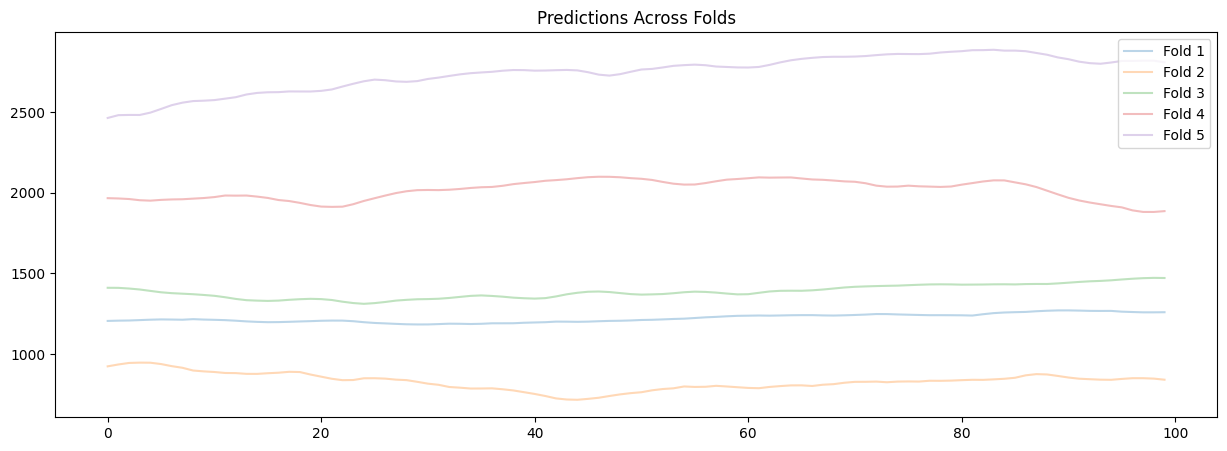


Bias-Variance Analysis Results:
Average Bias: 7420.161429
Average Variance: 699271.875000
Total Error（Bias + Variance）: 706692.036429

Model shows high variance (overfitting). Recommendations:
1. Increase regularization
2. Reduce model complexity
3. Add more training data
Bias: 7420.161429, Variance: 699271.875000

Step 2: Conducting Ablation Study

Testing configuration: base_model
X shape for LSTM: (5029, 5, 14)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1139 - val_loss: 0.0966
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0509 - val_loss: 0.0840
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413 - val_loss: 0.0822
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0396 - val_loss: 0.0714
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0355 - val_loss: 0.0617
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316 - val_loss: 0.0549
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0297 - val_loss: 0.0480
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0289 - val_loss: 0.0399
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0242 - val_loss: 0.0371
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0246 - val_loss: 0.0341
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - val_loss: 0.0315
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0217 - val_loss: 0.0338

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2202 - val_loss: 0.0657
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0417 - val_loss: 0.0425
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0395 - val_loss: 0.0343
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346 - val_loss: 0.0299
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304 - val_loss: 0.0268
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0277 - val_loss: 0.0261
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0257 - val_loss: 0.0256
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0237 - val_loss: 0.0237
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - val_loss: 0.0331
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0207 - val_loss: 0.0267
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0198 - val_loss: 0.0385
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0380


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1293 - val_loss: 0.0307
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0392 - val_loss: 0.0269
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 0.0257
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295 - val_loss: 0.0228
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0253 - val_loss: 0.0202
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0228 - val_loss: 0.0181
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - val_loss: 0.0160
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.0140
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - val_loss: 0.0124
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.0115
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0101
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0124 - val_loss: 0.0091


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1015 - val_loss: 0.0306
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0338 - val_loss: 0.0256
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0265 - val_loss: 0.0222
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0218 - val_loss: 0.0177
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0183 - val_loss: 0.0162
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.0153
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0121
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118 - val_loss: 0.0099
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1237 - val_loss: 1.4826
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0327 - val_loss: 0.9694
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0250 - val_loss: 0.6583
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0201 - val_loss: 0.4654
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.3573
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.3249
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.2453
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - val_loss: 0.1853
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.2364
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.2226
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - val_loss: 0.1920
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1303 - val_loss: 0.2696
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0487 - val_loss: 0.2147
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0416 - val_loss: 0.1751
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0372 - val_loss: 0.1597
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333 - val_loss: 0.1440
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0301 - val_loss: 0.1288
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0276 - val_loss: 0.1223
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - val_loss: 0.1076
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0233 - val_loss: 0.1040
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231 - val_loss: 0.0984
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0221 - val_loss: 0.0962
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0210 - val_loss: 0.0856

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1608 - val_loss: 0.1147
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0419 - val_loss: 0.1047
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0363 - val_loss: 0.0737
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0322 - val_loss: 0.0603
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0300 - val_loss: 0.0412
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0268 - val_loss: 0.0314
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0247 - val_loss: 0.0242
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0224 - val_loss: 0.0219
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0205 - val_loss: 0.0191
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190 - val_loss: 0.0185
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - val_loss: 0.0168
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - val_loss: 0.0170

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1668 - val_loss: 0.0344
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0415 - val_loss: 0.0297
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0347 - val_loss: 0.0275
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0298 - val_loss: 0.0251
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0264 - val_loss: 0.0223
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0237 - val_loss: 0.0208
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0210 - val_loss: 0.0177
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - val_loss: 0.0159
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0166 - val_loss: 0.0139
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_loss: 0.0131
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0113
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0129 - val_loss: 0.0101


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1200 - val_loss: 0.0606
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0321 - val_loss: 0.0409
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254 - val_loss: 0.0290
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0205 - val_loss: 0.0222
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0168 - val_loss: 0.0193
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - val_loss: 0.0135
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - val_loss: 0.0105
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_loss: 0.0099
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0111
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0685 - val_loss: 0.7640
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0282 - val_loss: 0.5308
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0202 - val_loss: 0.3210
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - val_loss: 0.2350
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.1994
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.2224
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0085 - val_loss: 0.2155
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0078 - val_loss: 0.1541
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071 - val_loss: 0.2037
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0064 - val_loss: 0.1981
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0060 - val_loss: 0.1599
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3260 - val_loss: 0.2851
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0657 - val_loss: 0.2340
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0523 - val_loss: 0.1907
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0461 - val_loss: 0.1647
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0421 - val_loss: 0.1454
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0364 - val_loss: 0.1306
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0353 - val_loss: 0.1200
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0332 - val_loss: 0.1088
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0306 - val_loss: 0.1004
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0296 - val_loss: 0.0919
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0287 - val_loss: 0.0882
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0284 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2347 - val_loss: 0.0483
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0488 - val_loss: 0.0398
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0410 - val_loss: 0.0697
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369 - val_loss: 0.0660
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0330 - val_loss: 0.0699
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0306 - val_loss: 0.0564
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0283 - val_loss: 0.0641
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0274 - val_loss: 0.0766
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0249 - val_loss: 0.0613
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237 - val_loss: 0.0873
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0222 - val_loss: 0.0898
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0207 - val_loss: 0.0739


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2024 - val_loss: 0.0364
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0480 - val_loss: 0.0358
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0400 - val_loss: 0.0323
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0338 - val_loss: 0.0309
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - val_loss: 0.0264
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0286 - val_loss: 0.0256
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0251 - val_loss: 0.0228
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0205
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210 - val_loss: 0.0183
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0196 - val_loss: 0.0166
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - val_loss: 0.0156
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 - val_loss: 0.0142


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0914 - val_loss: 0.0388
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0364 - val_loss: 0.0428
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0282 - val_loss: 0.0295
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0233 - val_loss: 0.0274
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0196 - val_loss: 0.0204
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0166 - val_loss: 0.0190
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0144 - val_loss: 0.0145
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0122 - val_loss: 0.0137
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0098 - val_loss: 0.0103
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1364 - val_loss: 0.8109
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0359 - val_loss: 0.5315
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0280 - val_loss: 0.3390
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0224 - val_loss: 0.2375
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0183 - val_loss: 0.1969
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - val_loss: 0.1684
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.1383
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0119 - val_loss: 0.1335
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.1011
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - val_loss: 0.1185
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_loss: 0.1084
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.6822 - val_loss: 0.1943
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1495 - val_loss: 0.1369
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0974 - val_loss: 0.1140
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0785 - val_loss: 0.0971
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0642 - val_loss: 0.0884
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0493 - val_loss: 0.0802
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0486 - val_loss: 0.0720
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0448 - val_loss: 0.0662
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0424 - val_loss: 0.0583
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0404 - val_loss: 0.0539
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0410 - val_loss: 0.0475
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0374 - val_loss: 0.0421

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1866 - val_loss: 0.0745
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0668 - val_loss: 0.0722
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0495 - val_loss: 0.0467
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0409 - val_loss: 0.0340
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0384 - val_loss: 0.0310
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0352 - val_loss: 0.0273
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 - val_loss: 0.0303
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0293 - val_loss: 0.0369
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0285 - val_loss: 0.0317
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0266 - val_loss: 0.0433
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0249 - val_loss: 0.0414
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0235 - val_loss: 0.0363

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1703 - val_loss: 0.0317
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0577 - val_loss: 0.0286
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0430 - val_loss: 0.0260
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0377 - val_loss: 0.0246
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343 - val_loss: 0.0225
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0312 - val_loss: 0.0208
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0269 - val_loss: 0.0185
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0246 - val_loss: 0.0181
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0230 - val_loss: 0.0171
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0209 - val_loss: 0.0161
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0194 - val_loss: 0.0155
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180 - val_loss: 0.0151


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1277 - val_loss: 0.0340
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0494 - val_loss: 0.0517
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0381 - val_loss: 0.0531
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0324 - val_loss: 0.0538
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0277 - val_loss: 0.0472
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0242 - val_loss: 0.0382
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0216 - val_loss: 0.0231
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0193 - val_loss: 0.0178
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0149 - val_loss: 0.0120
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0090
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1829 - val_loss: 1.0744
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0449 - val_loss: 0.7779
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0348 - val_loss: 0.5898
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0290 - val_loss: 0.4287
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245 - val_loss: 0.4189
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0217 - val_loss: 0.4253
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0199 - val_loss: 0.3033
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0167 - val_loss: 0.2771
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_loss: 0.2699
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143 - val_loss: 0.2662
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.1979
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4056 - val_loss: 0.4408
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0503 - val_loss: 0.3987
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0380 - val_loss: 0.3740
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0359 - val_loss: 0.3490
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0360 - val_loss: 0.3287
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0348 - val_loss: 0.3095
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0323 - val_loss: 0.2934
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0314 - val_loss: 0.2734
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0312 - val_loss: 0.2469
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0290 - val_loss: 0.2341
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0277 - val_loss: 0.2212
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0271 - val_loss: 0.2015

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2638 - val_loss: 0.0533
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0359 - val_loss: 0.0432
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0327 - val_loss: 0.0382
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0296 - val_loss: 0.0365
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0269 - val_loss: 0.0337
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0254 - val_loss: 0.0401
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0232 - val_loss: 0.0306
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - val_loss: 0.0303
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203 - val_loss: 0.0342
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0187 - val_loss: 0.0272
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0177 - val_loss: 0.0346
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0165 - val_loss: 0.0341

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1567 - val_loss: 0.0344
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - val_loss: 0.0310
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0311 - val_loss: 0.0270
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0272 - val_loss: 0.0237
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0238 - val_loss: 0.0210
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215 - val_loss: 0.0189
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0192 - val_loss: 0.0167
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0173 - val_loss: 0.0144
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0156 - val_loss: 0.0131
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0138 - val_loss: 0.0116
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - val_loss: 0.0105
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0117 - val_loss: 0.0096


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1021 - val_loss: 0.0641
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0302 - val_loss: 0.0538
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254 - val_loss: 0.0345
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0210 - val_loss: 0.0265
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177 - val_loss: 0.0181
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0152 - val_loss: 0.0137
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0114
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - val_loss: 0.0101
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - val_loss: 0.0091
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1293 - val_loss: 1.0601
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0286 - val_loss: 0.8141
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0228 - val_loss: 0.6357
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0176 - val_loss: 0.5549
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.4308
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0121 - val_loss: 0.3999
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - val_loss: 0.3205
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.2786
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0077 - val_loss: 0.2387
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - val_loss: 0.2327
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.2019
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3592 - val_loss: 0.1205
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0513 - val_loss: 0.0940
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381 - val_loss: 0.0745
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0338 - val_loss: 0.0493
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0275 - val_loss: 0.0442
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0237 - val_loss: 0.0314
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0211 - val_loss: 0.0292
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - val_loss: 0.0254
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - val_loss: 0.0253
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - val_loss: 0.0220
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0136 - val_loss: 0.0245
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0132 - val_loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1560 - val_loss: 0.0398
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0319 - val_loss: 0.0237
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0211 - val_loss: 0.0229
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.0283
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - val_loss: 0.0175
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0187
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0085 - val_loss: 0.0247
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0277
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0193
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - val_loss: 0.0192
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0058 - val_loss: 0.0313
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0059 - val_loss: 0.024

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1207 - val_loss: 0.0248
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0250 - val_loss: 0.0181
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - val_loss: 0.0137
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0042

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0786 - val_loss: 0.0174
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0135 - val_loss: 0.0085
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0105
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0735 - val_loss: 0.1596
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.1030
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0076 - val_loss: 0.0855
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - val_loss: 0.1219
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0064 - val_loss: 0.2256
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0055 - val_loss: 0.0971
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - val_loss: 0.1779
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - val_loss: 0.0474
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0984
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0059 - val_loss: 0.0522
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.1549
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5237 - val_loss: 0.1217
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1633 - val_loss: 0.1203
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0618 - val_loss: 0.1245
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0617 - val_loss: 0.1164
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0585 - val_loss: 0.1087
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0540 - val_loss: 0.1031
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0584 - val_loss: 0.0976
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0530 - val_loss: 0.0935
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0528 - val_loss: 0.0910
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0514 - val_loss: 0.0873
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0518 - val_loss: 0.0853
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0510 - val_loss: 0.0832

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3607 - val_loss: 0.1499
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0609 - val_loss: 0.0850
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0544 - val_loss: 0.0663
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0548 - val_loss: 0.0587
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0501 - val_loss: 0.0504
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510 - val_loss: 0.0483
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0488 - val_loss: 0.0441
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0466 - val_loss: 0.0428
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0459 - val_loss: 0.0404
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0447 - val_loss: 0.0393
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0450 - val_loss: 0.0392
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0429 - val_loss: 0.037

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6219 - val_loss: 0.1240
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1126 - val_loss: 0.0852
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0601 - val_loss: 0.0693
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0600 - val_loss: 0.0630
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0555 - val_loss: 0.0581
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0526 - val_loss: 0.0541
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0513 - val_loss: 0.0513
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0488 - val_loss: 0.0469
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0488 - val_loss: 0.0447
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0461 - val_loss: 0.0425
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0442 - val_loss: 0.0396
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0442 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.5235 - val_loss: 0.1473
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0602 - val_loss: 0.1108
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0495 - val_loss: 0.1061
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0490 - val_loss: 0.0993
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0453 - val_loss: 0.0941
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0446 - val_loss: 0.0892
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0417 - val_loss: 0.0844
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0409 - val_loss: 0.0794
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0389 - val_loss: 0.0762
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0380 - val_loss: 0.0745
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0376 - val_loss: 0.0696
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4657 - val_loss: 2.1161
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0782 - val_loss: 1.5107
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0524 - val_loss: 1.2946
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0475 - val_loss: 1.1998
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0450 - val_loss: 1.1621
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0428 - val_loss: 1.1343
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0407 - val_loss: 1.0762
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0399 - val_loss: 1.0451
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0384 - val_loss: 0.9749
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0365 - val_loss: 0.9391
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0360 - val_loss: 0.9320
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2257 - val_loss: 0.0619
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0543 - val_loss: 0.0534
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0438 - val_loss: 0.0516
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0409 - val_loss: 0.0500
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0389 - val_loss: 0.0489
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0331 - val_loss: 0.0444
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0320 - val_loss: 0.0423
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0293 - val_loss: 0.0427
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0300 - val_loss: 0.0370
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274 - val_loss: 0.0360
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0271 - val_loss: 0.0363
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3399 - val_loss: 0.0405
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - val_loss: 0.0340
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0428 - val_loss: 0.0334
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0405 - val_loss: 0.0343
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0358 - val_loss: 0.0374
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0301 - val_loss: 0.0407
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0278 - val_loss: 0.0350
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0269 - val_loss: 0.0391
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0247 - val_loss: 0.0419
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0236 - val_loss: 0.0361
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0533
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - val_loss: 0.054

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1837 - val_loss: 0.0286
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0440 - val_loss: 0.0242
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0381 - val_loss: 0.0248
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0310 - val_loss: 0.0249
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0281 - val_loss: 0.0225
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0256 - val_loss: 0.0219
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - val_loss: 0.0201
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0215 - val_loss: 0.0191
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201 - val_loss: 0.0191
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0187 - val_loss: 0.0170
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0172 - val_loss: 0.0162
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0164 - val_loss: 0.0148


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1772 - val_loss: 0.0584
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0378 - val_loss: 0.0429
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0309 - val_loss: 0.0325
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0259 - val_loss: 0.0263
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0233 - val_loss: 0.0230
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0213 - val_loss: 0.0202
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0194 - val_loss: 0.0185
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0173 - val_loss: 0.0162
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.0146
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0881 - val_loss: 0.9244
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0328 - val_loss: 0.5933
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0244 - val_loss: 0.5468
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - val_loss: 0.5457
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175 - val_loss: 0.4808
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.4822
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0136 - val_loss: 0.4667
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.4941
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106 - val_loss: 0.4718
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - val_loss: 0.4795
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - val_loss: 0.4337
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.4092 - val_loss: 0.1769
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1235 - val_loss: 0.1539
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1066 - val_loss: 0.1304
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1001 - val_loss: 0.1137
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0901 - val_loss: 0.1012
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0839 - val_loss: 0.0929
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0771 - val_loss: 0.0840
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0722 - val_loss: 0.0779
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0663 - val_loss: 0.0714
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0644 - val_loss: 0.0711
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0601 - val_loss: 0.0692
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0571 - val_loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2983 - val_loss: 0.0985
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1003 - val_loss: 0.0862
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0878 - val_loss: 0.0792
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0751 - val_loss: 0.0723
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0653 - val_loss: 0.0617
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0578 - val_loss: 0.0554
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0520 - val_loss: 0.0538
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0468 - val_loss: 0.0538
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0413 - val_loss: 0.0470
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0374 - val_loss: 0.0458
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0348 - val_loss: 0.0487
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0323 - val_loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1717 - val_loss: 0.0888
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0869 - val_loss: 0.0688
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0668 - val_loss: 0.0537
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0519 - val_loss: 0.0445
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0432 - val_loss: 0.0363
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0368 - val_loss: 0.0317
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0320 - val_loss: 0.0302
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0281 - val_loss: 0.0289
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0249 - val_loss: 0.0276
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0230 - val_loss: 0.0282
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0211 - val_loss: 0.0268
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0194 - val_loss: 0.027

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1799 - val_loss: 0.0944
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0746 - val_loss: 0.0654
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0531 - val_loss: 0.0552
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0405 - val_loss: 0.0446
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0323 - val_loss: 0.0435
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0279 - val_loss: 0.0434
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0236 - val_loss: 0.0358
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0210 - val_loss: 0.0317
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0191 - val_loss: 0.0379
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0168 - val_loss: 0.0311
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0154 - val_loss: 0.0339
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1636 - val_loss: 1.0065
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0627 - val_loss: 0.7241
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0407 - val_loss: 0.5645
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0308 - val_loss: 0.4856
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0254 - val_loss: 0.4813
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0217 - val_loss: 0.4126
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0194 - val_loss: 0.3972
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0174 - val_loss: 0.3945
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159 - val_loss: 0.3894
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0142 - val_loss: 0.4550
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_loss: 0.3851
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.5455 - val_loss: 0.4068
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2887 - val_loss: 0.3321
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2405 - val_loss: 0.2698
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2009 - val_loss: 0.2170
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1728 - val_loss: 0.1738
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1466 - val_loss: 0.1470
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1294 - val_loss: 0.1280
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1170 - val_loss: 0.1125
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1050 - val_loss: 0.1030
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0959 - val_loss: 0.0999
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0891 - val_loss: 0.0897
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0825 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.4336 - val_loss: 0.2360
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2159 - val_loss: 0.1553
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1466 - val_loss: 0.1130
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1089 - val_loss: 0.0884
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0876 - val_loss: 0.0764
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0732 - val_loss: 0.0688
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0617 - val_loss: 0.0751
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0539 - val_loss: 0.0579
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0460 - val_loss: 0.0619
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0421 - val_loss: 0.0690
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0378 - val_loss: 0.0657
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0343 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.4033 - val_loss: 0.1890
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1612 - val_loss: 0.1164
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0978 - val_loss: 0.0841
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0720 - val_loss: 0.0702
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0555 - val_loss: 0.0670
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0457 - val_loss: 0.0622
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0386 - val_loss: 0.0623
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0329 - val_loss: 0.0646
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0284 - val_loss: 0.0611
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0252 - val_loss: 0.0627
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0226 - val_loss: 0.0734
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0205 - val_loss: 0.069

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3417 - val_loss: 0.1594
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1162 - val_loss: 0.0954
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0684 - val_loss: 0.0700
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0487 - val_loss: 0.0684
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0376 - val_loss: 0.0570
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0300 - val_loss: 0.0584
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0255 - val_loss: 0.0596
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0212 - val_loss: 0.0603
Epoch 9/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0183 - val_loss: 0.0667
Epoch 10/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0165 - val_loss: 0.0782
Epoch 11/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0142 - val_loss: 0.0686
Epoch 12/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.3363 - val_loss: 0.7949
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0977 - val_loss: 0.6239
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0593 - val_loss: 0.5149
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0429 - val_loss: 0.4683
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0335 - val_loss: 0.4657
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0272 - val_loss: 0.3250
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0235 - val_loss: 0.4397
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0196 - val_loss: 0.5205
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0181 - val_loss: 0.3440
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0171 - val_loss: 0.3946
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0151 - val_loss: 0.5514
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0868 - val_loss: 1.0157
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0337 - val_loss: 0.6414
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0257 - val_loss: 0.4195
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0209 - val_loss: 0.2654
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0171 - val_loss: 0.1964
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0141 - val_loss: 0.1657
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122 - val_loss: 0.1394
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - val_loss: 0.1402
Epoch 9/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0111 - val_loss: 0.1020
Epoch 10/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0085 - val_loss: 0.1181
Epoch 11/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0075 - val_loss: 0.1093
Epoch 12/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

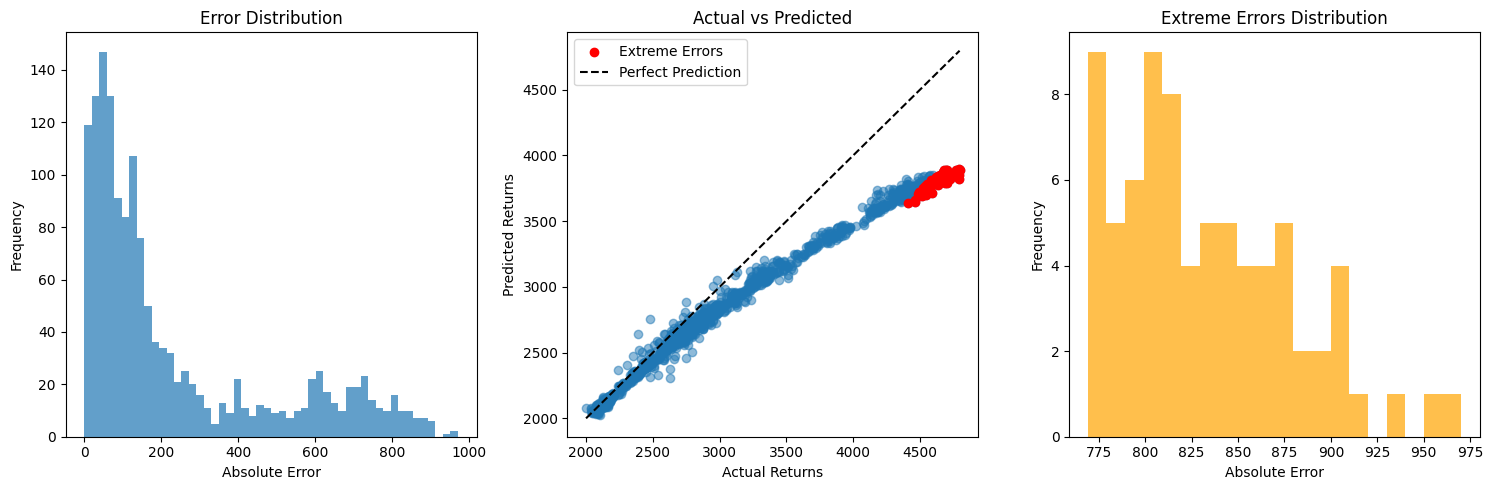


Step 6: Visualizing Results


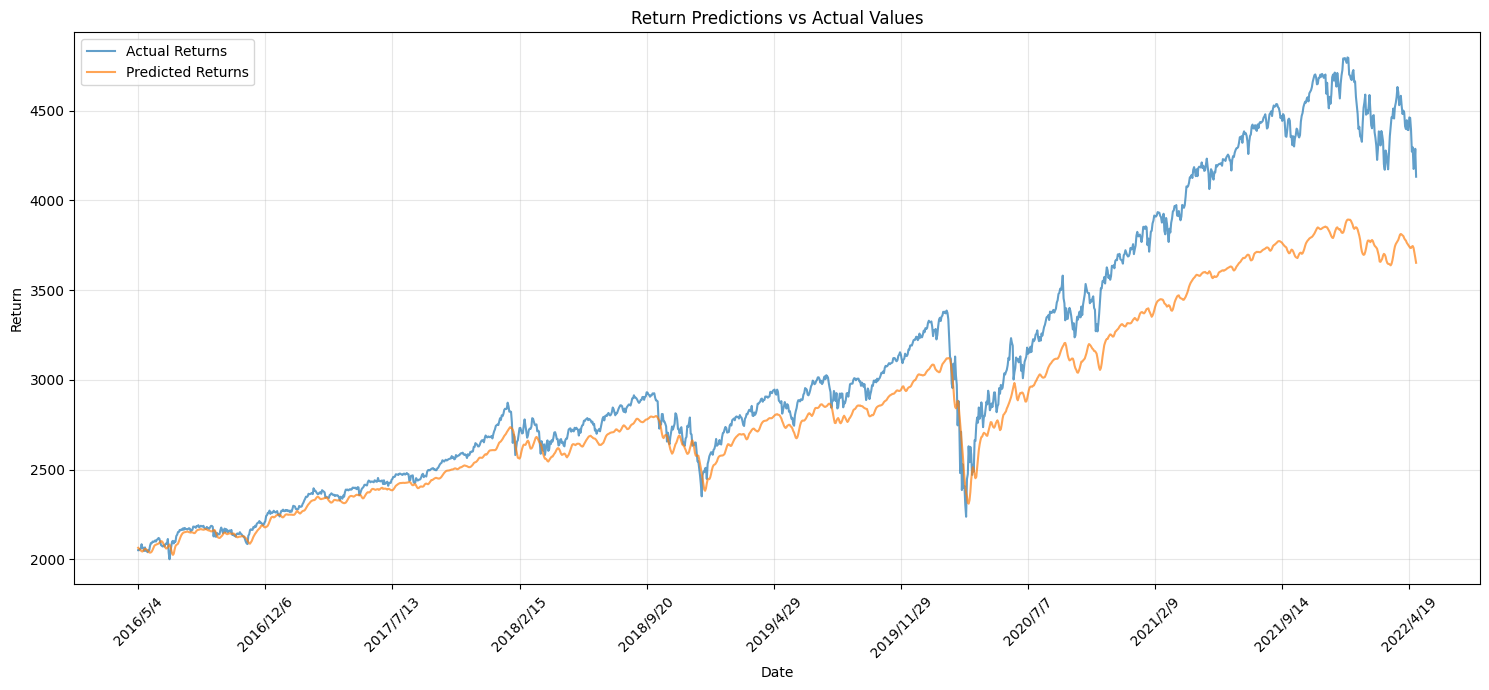

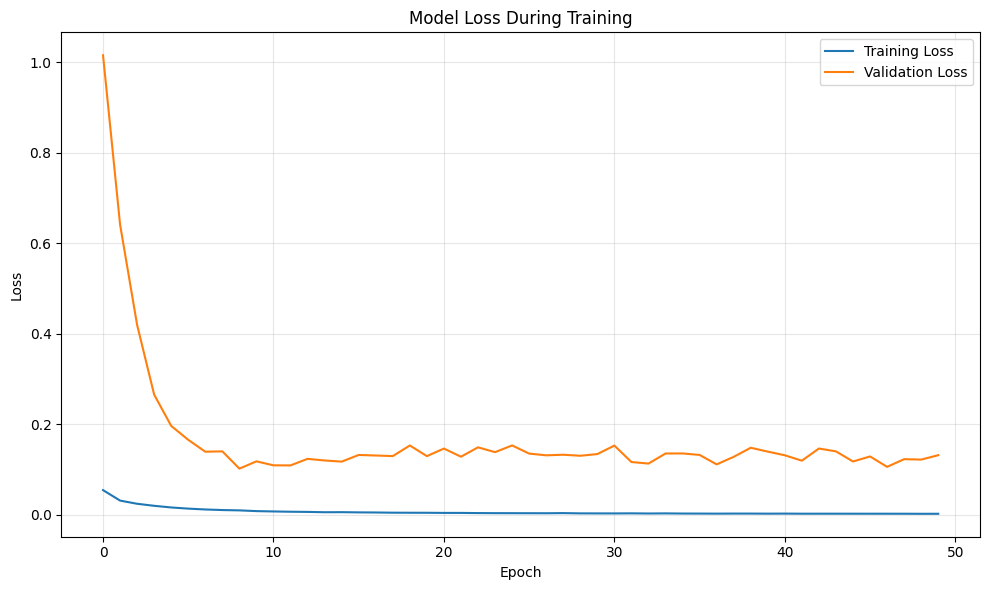

In [21]:
predictions, actual_values, train_losses, val_losses = predict_returns(data, seq_length=5)